In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

1. 采用sift特征检测算法检测两幅图像的关键特征点

2. 采用knn检测函数进行特征匹配并可视化

3. 从所匹配的全部关键点中筛选出优秀的特征点（基于距离筛选）

4. 用 RANSAC 算法来计算透视变换矩阵 H

使用 OpenCV 进行 SIFT 特征提取

In [3]:
def Get_features(gray_image):

    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    
    return keypoints, descriptors


采用knn检测函数进行特征匹配
1、获取匹配的关键点用以可视化
2、用 RANSAC 算法来计算透视变换矩阵 H，并返回变换矩阵、匹配特征点对和状态信息

In [4]:
# 采用knn检测函数进行特征匹配，获取匹配的关键点用以可视化
def Get_match(feature_1,feature_2):
    bf = cv2.BFMatcher()
    rawMatches = bf.knnMatch(feature_1, feature_2, k=2)

    matches = []
    #过滤
    for m,n in rawMatches:
            if m.distance < 0.75 * n.distance:
                matches.append(m)
                        
    return  matches

# 采用knn检测函数进行特征匹配，用 RANSAC 算法来计算透视变换矩阵 H，并返回变换矩阵、匹配特征点对和状态信息
def matchKeypoints(keypoints_1, keypoints_2, features_1, features_2, ratio, reprojThresh):
        # 创建BFMatcher对象
        matcher = cv2.BFMatcher()
        # 使用BFMatcher进行特征点匹配
        rawMatches = matcher.knnMatch(features_1, features_2, 2)
        
        #受cv2.findHomography()函数输入限制，更改类型
        keypoints_1 = np.float32([kp.pt for kp in keypoints_1])
        keypoints_2 = np.float32([kp.pt for kp in keypoints_2])
        
        matches = []
        for m in rawMatches:
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                matches.append((m[0].trainIdx, m[0].queryIdx))

       #如果筛选后的匹配特征点对数量大于 4，则将这些特征点对转换为 NumPy 数组
        if len(matches) > 4:
            ptsA = np.float32([keypoints_1[i] for (_, i) in matches])
            ptsB = np.float32([keypoints_2[i] for (i, _) in matches])
            
            #用 RANSAC 算法来计算透视变换矩阵 H，并返回变换矩阵、匹配特征点对和状态信息。
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)
            
            return (matches, H, status)
        
        else:
            print("可匹配的特征点数量较低")

获取图片，显示图片并保存

In [16]:
#  获取图片
def Get_img(image_path):
    image =  cv2.imread(image_path)
    #OpenCV中读取的图像是以BGR（蓝绿红）顺序进行编码的，需要将图像转换为RGB格式进行处理
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #防止图片过大
    img = cv2.resize(image, (1028, 762))
    return img

# 显示图片并保存
def show_img(name,img):
    #获取图片时转换为RGB格式，显示图片则需要转换为BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.text(img.shape[1]//2,img.shape[0]+150,name,color='red', fontsize=12, ha='center')
    cv2.imwrite('img/practice_4_'+ name  + '.jpg', img)
    plt.show()
    
#拼接显示
def show(image1,image2):

    image1 = cv2.cvtColor(image1, cv2.COLOR_RGB2BGR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    
    # 水平拼接两张图像
    concatenated_image = np.hstack((image1, image2))

    # 显示拼接后的图像
    plt.imshow(concatenated_image)
    plt.axis('off')
    
    cv2.imwrite('img/practice_4_image_with_keypoints.jpg', concatenated_image)
    # 对第一张图像添加标注
    plt.text(image1.shape[1] // 2, image1.shape[0] + 60, 'Image with Keypoints_1 ', color='red', fontsize=12, ha='center')

    # 对第二张图像添加标注
    plt.text(image1.shape[1] + image2.shape[1] // 2, image1.shape[0] + 60, 'Image with Keypoints_2', color='blue', fontsize=12, ha='center')

    plt.show()

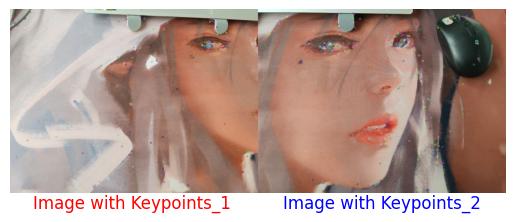

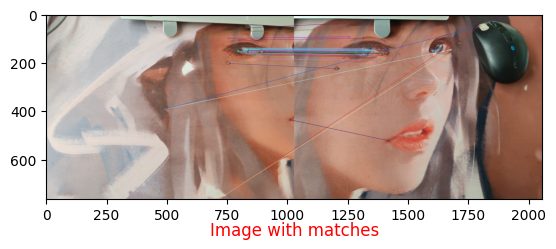

这两张图片的单应性矩阵：
 [[ 8.82768250e-01  2.88376908e-01  5.43252797e+02]
 [ 3.49775456e-02  7.89820325e-01  2.08319614e+01]
 [ 1.05816209e-04 -3.02931501e-05  1.00000000e+00]]


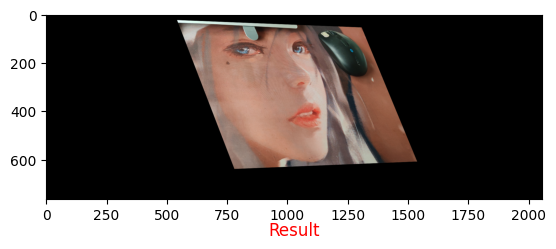

In [17]:
if __name__ == "__main__":
    
    image_path_1 = 'img/IMG1.jpg'
    image_path_2 = 'img/IMG2.jpg'

    #获取图片
    image_1 = Get_img(image_path_1)
    image_2 = Get_img(image_path_2)

    #获取特征点，描述符
    keypoints_1, descriptors_1 = Get_features(image_1)
    keypoints_2, descriptors_2 = Get_features(image_2)
    
    #在图中画出特征点
    image_with_keypoints_1 = cv2.drawKeypoints(image_1, keypoints_1, None)
    image_with_keypoints_2 = cv2.drawKeypoints(image_2, keypoints_2, None)
    show(image_with_keypoints_1,image_with_keypoints_2)
    
    #显示图片的关键点
    match = Get_match(descriptors_1,descriptors_2)
    #绘制K近邻匹配结果
    image_with_match = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2,match,None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    show_img('Image with matches',image_with_match)
    
   
    M = matchKeypoints(keypoints_2, keypoints_1, descriptors_2, descriptors_1, ratio = 0.75, reprojThresh = 4.0)
    if M is None:
        print("Error!")
    (matches, H, status) = M
    
    print('这两张图片的单应性矩阵：\n',H)
    
    #使用透视变换矩阵H对image_1进行透视变换，得到变换后的结果图像result
    result = cv2.warpPerspective(image_2, H, (image_1.shape[1] + image_2.shape[1], max(image_1.shape[0],image_2.shape[0])))
    show_img('Result',result)